In [1]:
!mkdir ~/.kaggle

In [2]:
cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download arunrk7/surface-crack-detection

Dataset URL: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection
License(s): copyright-authors
 98% 228M/233M [00:07<00:00, 34.0MB/s]
100% 233M/233M [00:07<00:00, 31.2MB/s]


In [4]:
import zipfile
with zipfile.ZipFile("surface-crack-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("crack_detection")

In [5]:
import os
import random
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


dataset = "/content/crack_detection"
new_dataset = "/content/dataset"
os.makedirs(new_dataset, exist_ok=True)

train_dir = os.path.join(new_dataset, "train")
val_dir = os.path.join(new_dataset, "val")
test_dir = os.path.join(new_dataset, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [7]:
num_class = os.listdir(dataset)
num_class = len(num_class)
print(num_class)

2


In [8]:
for label in os.listdir(dataset):
  print(label)

Negative
Positive


In [6]:
# Proporsi dataset
train_split = 0.7
val_split = 0.2
test_split = 0.1

# Membagi file berdasarkan proporsi
for label in os.listdir(dataset):
    class_dir = os.path.join(dataset, label)
    if not os.path.isdir(class_dir):
        continue

    files = os.listdir(class_dir)
    random.shuffle(files)

    train_count = int(len(files) * train_split)
    val_count = int(len(files) * val_split)

    # Pindahkan file
    for i, file in enumerate(files):
        src = os.path.join(class_dir, file)
        if i < train_count:
            dst = os.path.join(train_dir, label)
        elif i < train_count + val_count:
            dst = os.path.join(val_dir, label)
        else:
            dst = os.path.join(test_dir, label)

        os.makedirs(dst, exist_ok=True)
        shutil.move(src, os.path.join(dst, file))

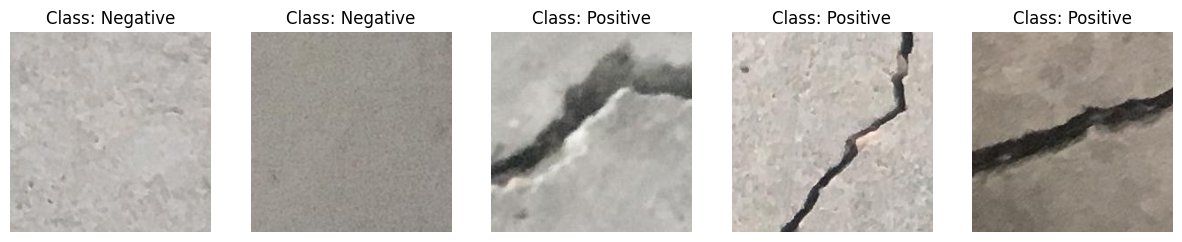

In [7]:
import matplotlib.pyplot as plt
import random
from PIL import Image

def display_random_images(directory, num_images=5):
    images = []
    labels = []

    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if not os.path.isdir(class_dir):
            continue

        files = os.listdir(class_dir)
        for file in files:
            images.append(os.path.join(class_dir, file))
            labels.append(label)

    # Randomly select images
    selected_images = random.sample(images, num_images)

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(selected_images):
        with Image.open(img_path) as img:
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.title(f"Class: {labels[images.index(img_path)]}")
            plt.axis('off')
    plt.show()

# Display 3 random images dari train dataset
display_random_images(train_dir)

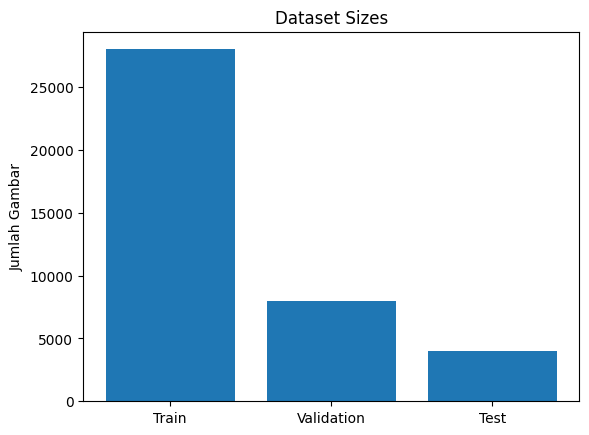

Train Dataset: 28000 images with unique shapes: [[227 227]]
Validation Dataset: 8000 images
Test Dataset: 4000 images


In [8]:
import numpy as np
from PIL import Image

def analyze_dataset(directory):
    image_shapes = []
    total_count = 0
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if not os.path.isdir(class_dir):
            continue

        files = os.listdir(class_dir)
        total_count += len(files)

        for file in files:
            file_path = os.path.join(class_dir, file)
            try:
                with Image.open(file_path) as img:
                    image_shapes.append(img.size)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    return total_count, image_shapes

# Analyze train, val, and test datasets
train_count, train_shapes = analyze_dataset(train_dir)
val_count, val_shapes = analyze_dataset(val_dir)
test_count, test_shapes = analyze_dataset(test_dir)

dataset_sizes = {'Train': train_count, 'Validation': val_count, 'Test': test_count}
image_shapes = {'Train': train_shapes, 'Validation': val_shapes, 'Test': test_shapes}

# Plot dataset sizes
plt.bar(dataset_sizes.keys(), dataset_sizes.values())
plt.title('Dataset Sizes')
plt.ylabel('Jumlah Gambar')
plt.show()

unique_shapes = np.unique(train_shapes, axis=0)
print(f"Train Dataset: {train_count} images with unique shapes: {unique_shapes}")
print(f"Validation Dataset: {val_count} images")
print(f"Test Dataset: {test_count} images")


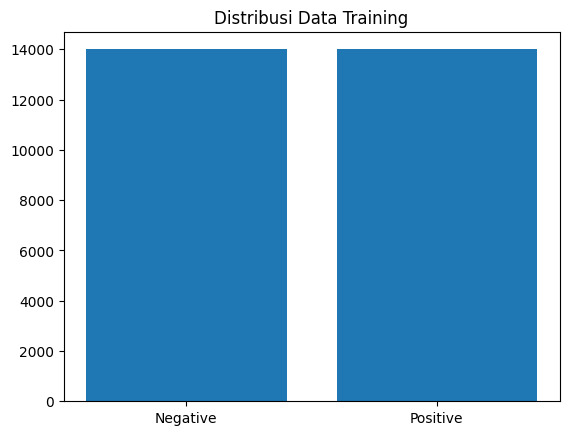

In [9]:
def analyze_distribution(directory):
    class_counts = {}
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            class_counts[label] = len(os.listdir(class_dir))
    return class_counts

train_dist = analyze_distribution(train_dir)
val_dist = analyze_distribution(val_dir)
test_dist = analyze_distribution(test_dir)

# Visualisasi distribusi
plt.bar(train_dist.keys(), train_dist.values())
plt.title("Distribusi Data Training")
plt.show()

In [13]:
# Augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=20,
    # horizontal_flip=True,
    # shear_range=0.2,
    # zoom_range=0.2,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
    # shuffle=True,
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
)


Found 28000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [14]:
print(train_generator.class_indices)
print(val_generator.class_indices)

{'Negative': 0, 'Positive': 1}
{'Negative': 0, 'Positive': 1}


In [15]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

<ipython-input-15-5f8366972d5c>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    batch_size = 64
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 127s 180ms/step - accuracy: 0.8043 - loss: 2.7117 - val_accuracy: 0.5594 - val_loss: 3.5978
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 94s 130ms/step - accuracy: 0.9919 - loss: 2.1688 - val_accuracy: 0.7193 - val_loss: 2.8673
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 54s 122ms/step - accuracy: 0.9969 - loss: 1.9313 - val_accuracy: 0.8832 - val_loss: 2.0834
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 57s 130ms/step - accuracy: 0.9975 - loss: 1.6979 - val_accuracy: 0.9471 - val_loss: 1.6723
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 55s 124ms/step - accuracy: 0.9981 - loss: 1.4711 - val_accuracy: 0.9826 - val_loss: 1.3565
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 124ms/step - accuracy: 0.9990 - loss: 1.2543 - val_accuracy: 0.9939 - val_loss: 1.1180
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 124ms/step - accuracy: 0.9994 - loss: 1.0533 - val_accuracy: 0.9959 - val_loss: 0.9237
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 54s 122ms/step - accuracy: 0.9990 - loss: 0.8727 - va

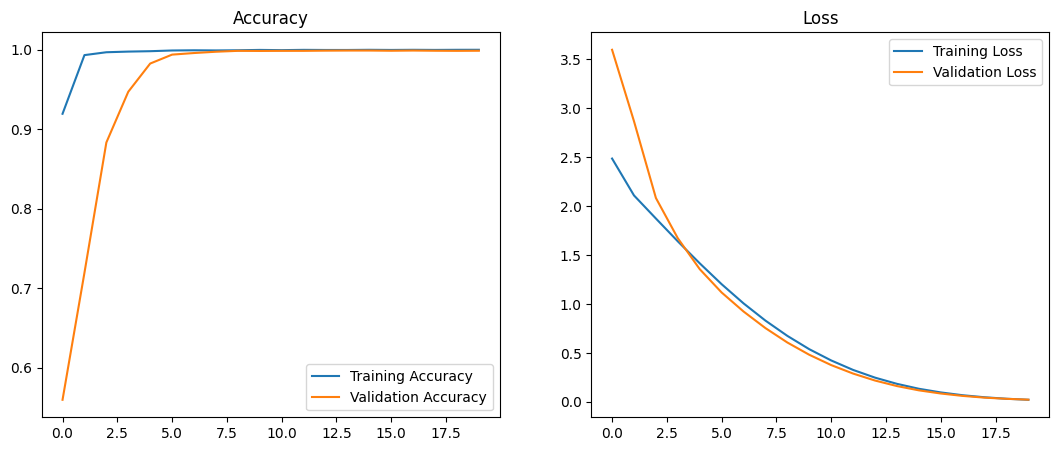

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()
model.save("crack_mobilenetv3.h5")

Found 4000 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9992 - loss: 0.0206
Test Loss: 0.020580152049660683
Test Accuracy: 0.9992499947547913
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step


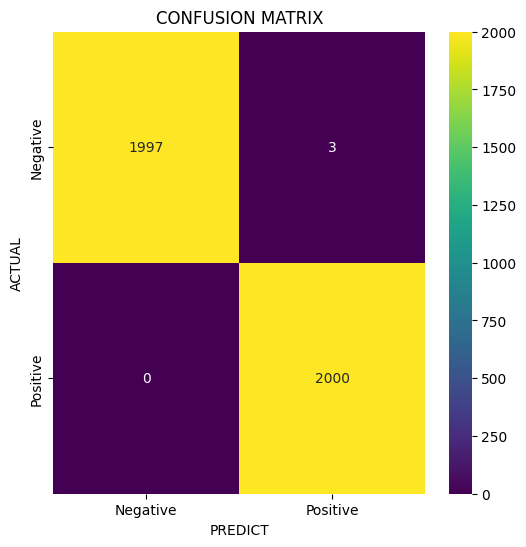

ClASSIFICATION REPORT:
----------------------
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2000
    Positive       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = np.squeeze((model.predict(test_generator) >= 0.5).astype(int))
cm = confusion_matrix(test_generator.labels, y_pred)
clr = classification_report(test_generator.labels, y_pred, target_names=["Negative", "Positive"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True,fmt= 'g', vmin=0, cmap='viridis')
plt.xticks(ticks=np.arange(2) + 0.5, labels=["Negative", "Positive"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["Negative", "Positive"])
plt.xlabel("PREDICT")
plt.ylabel("ACTUAL")
plt.title("CONFUSION MATRIX")
plt.show()
print("ClASSIFICATION REPORT:\n----------------------\n", clr)

In [20]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Pilih 10 gambar acak dari test
test_images = []
image_paths = []
for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    images = os.listdir(label_path)
    selected_images = random.sample(images, 2)
    for image in selected_images:
        image_paths.append(os.path.join(label_path, image))
        img = load_img(os.path.join(label_path, image), target_size=(150, 150))
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Rescale
        test_images.append(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


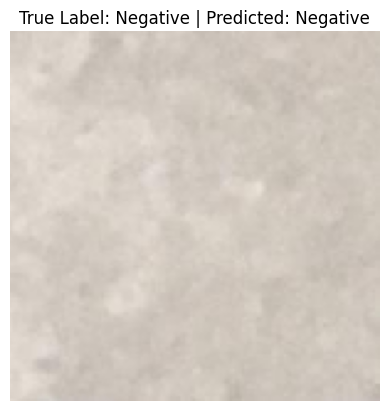

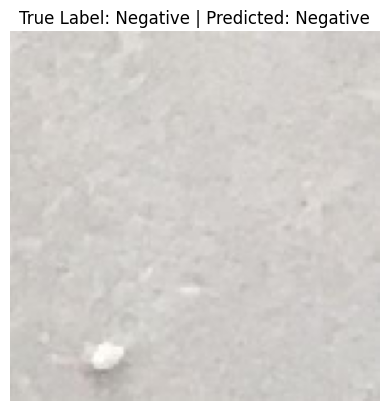

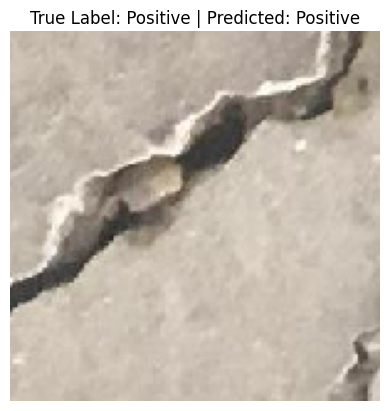

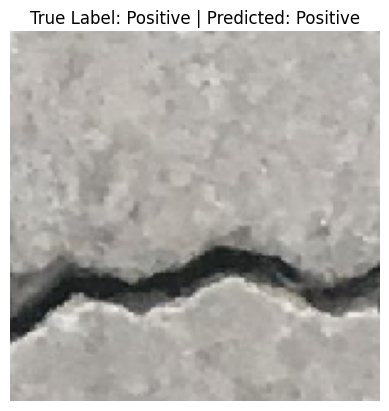

In [21]:
test_images = np.array(test_images)
class_labels = ['Negative', 'Positive']
# Perform predictions
predicted_classes = np.squeeze((model.predict(test_images) >= 0.5).astype(int)) #np.argmax(predictions, axis=1)
true_labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Display images with predicted and true labels
for i, image_path in enumerate(image_paths):
    img = load_img(image_path, target_size=(150, 150))
    plt.imshow(img)

    predicted_label = class_labels[predicted_classes[i]]
    true_label = true_labels[i]

    plt.title(f"True Label: {true_label} | Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

In [10]:
# Augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=20,
    # horizontal_flip=True,
    # shear_range=0.2,
    # zoom_range=0.2,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
    # shuffle=True,
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
)


Found 28000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [11]:
base_model_2 = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(150,150,3),
    pooling=None,
    classes=None,
    classifier_activation=None,
    name="inception_v3",
)

x = base_model_2.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model_2 = Model(inputs=base_model_2.input, outputs=predictions)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [12]:
for layer in base_model_2.layers[-20:]:
    layer.trainable = True

model_2.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model_2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    batch_size = 64
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8394 - loss: 2.7103

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 222s 313ms/step - accuracy: 0.8397 - loss: 2.7098 - val_accuracy: 0.9958 - val_loss: 2.1784
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 101s 200ms/step - accuracy: 0.9955 - loss: 2.1012 - val_accuracy: 0.9970 - val_loss: 1.8533
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 88s 200ms/step - accuracy: 0.9985 - loss: 1.7719 - val_accuracy: 0.9976 - val_loss: 1.5379
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 141s 198ms/step - accuracy: 0.9986 - loss: 1.4626 - val_accuracy: 0.9984 - val_loss: 1.2488
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 89s 202ms/step - accuracy: 0.9997 - loss: 1.1791 - val_accuracy: 0.9981 - val_loss: 0.9937
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 142s 202ms/step - accuracy: 0.9997 - loss: 0.9313 - val_accuracy: 0.9984 - val_loss: 0.7719
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 142s 202ms/step - accuracy: 0.9998 - loss: 0.7186 - val_accuracy: 0.9985 - val_loss: 0.5852
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 142s 203ms/step - accuracy: 1.0000 - loss: 0.5413

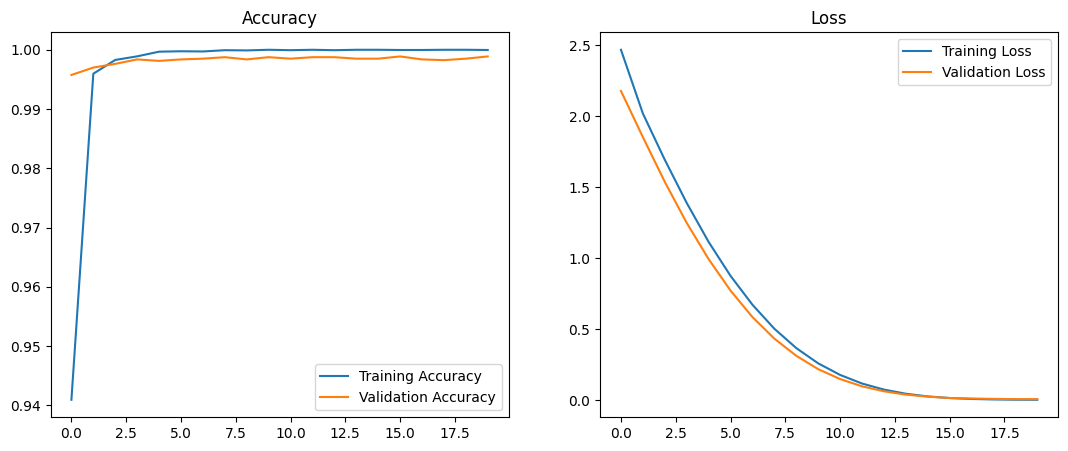

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()
model_2.save("crack_inceptionv3.h5")

Found 4000 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.9991 - loss: 0.0068
Test Loss: 0.006047074217349291
Test Accuracy: 0.9992499947547913
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step


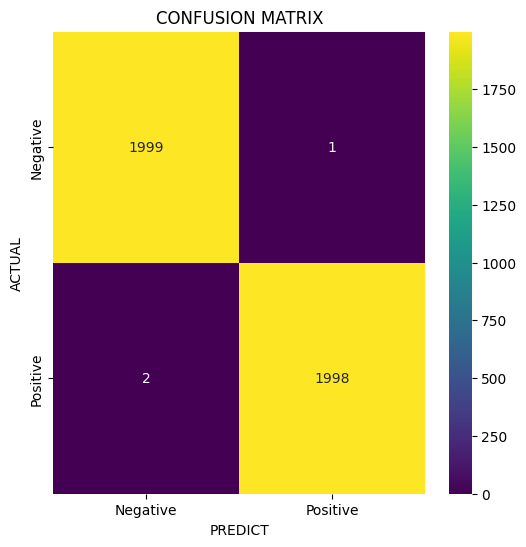

ClASSIFICATION REPORT:
----------------------
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2000
    Positive       1.00      1.00      1.00      2000

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
test_loss, test_accuracy = model_2.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = np.squeeze((model_2.predict(test_generator) >= 0.5).astype(int))
cm = confusion_matrix(test_generator.labels, y_pred)
clr = classification_report(test_generator.labels, y_pred, target_names=["Negative", "Positive"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True,fmt= 'g', vmin=0, cmap='viridis')
plt.xticks(ticks=np.arange(2) + 0.5, labels=["Negative", "Positive"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["Negative", "Positive"])
plt.xlabel("PREDICT")
plt.ylabel("ACTUAL")
plt.title("CONFUSION MATRIX")
plt.show()
print("ClASSIFICATION REPORT:\n----------------------\n", clr)

In [17]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Pilih 10 gambar acak dari test
test_images = []
image_paths = []
for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    images = os.listdir(label_path)
    selected_images = random.sample(images, 2)
    for image in selected_images:
        image_paths.append(os.path.join(label_path, image))
        img = load_img(os.path.join(label_path, image), target_size=(150, 150))
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Rescale
        test_images.append(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


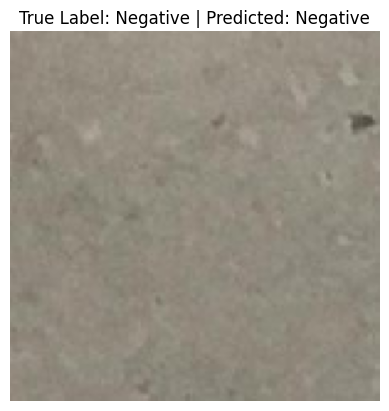

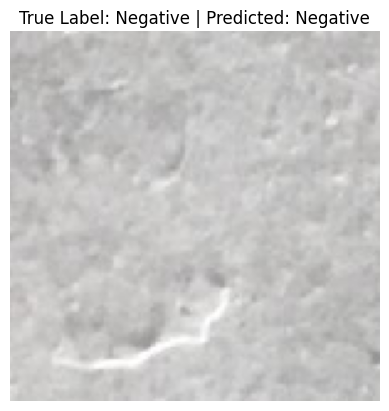

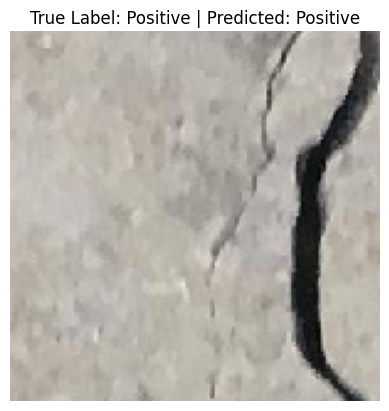

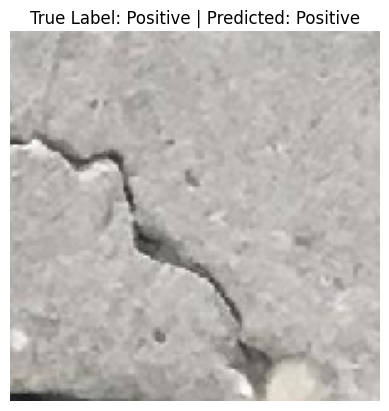

In [19]:
test_images = np.array(test_images)

# Perform predictions
predicted_classes = np.squeeze((model_2.predict(test_images) >= 0.5).astype(int)) #np.argmax(predictions, axis=1)
true_labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]
class_labels = ['Negative', 'Positive']
# Display images with predicted and true labels
for i, image_path in enumerate(image_paths):
    img = load_img(image_path, target_size=(150, 150))
    plt.imshow(img)

    predicted_label = class_labels[predicted_classes[i]]
    true_label = true_labels[i]

    plt.title(f"True Label: {true_label} | Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

In [ ]:
cek = os.listdir(train_dir)
print(cek)